# **Project I**

###### - Team Members: Karen Lin, Kevin Zhang, Sunjae Youm </br> - 6/17/2024 </br> - Data Source: https://catalog.data.gov/dataset/crash-reporting-drivers-data/resource/9851a37f-4f32-464e-8ba6-c23023653a7f

### **Abstract**
Our data team assumed that we received a request from the Montgomery County local government in Maryland. The purpose of the request was to determine how to use the county budget to improve traffic and reduce car accidents. Additionally, Montgomery County wanted to choose a specific municipality and asked us, as data analysts, to identify which roads had the most car accidents. To achieve this, we investigated traffic accident records from January 2015 to March 2024, analyzing the areas with the highest accident rates, the time periods with the most accidents, and whether there were traffic control regulations in place at the accident locations.

In [50]:
# Dependencies

import pandas as pd
import numpy as np
import requests
import json
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the car_crash_drivers_report
car_crash_df = pd.read_csv("./Resources/Crash_Reporting_-_Drivers_Data.csv")
car_crash_df.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,05/31/2019 03:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,...,15,No,No,2004,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,EJ78850038,230034791,Gaithersburg Police Depar,Property Damage Crash,07/21/2023 05:59:00 PM,Maryland (State),FREDERICK RD,Unknown,WATKINS MILL RD,NaN,...,40,No,No,2011,GMC,TK,NO MISUSE,39.159264,-77.219025,"(39.1592635, -77.21902483)"
2,MCP2009002G,230034583,Montgomery County Police,Property Damage Crash,07/20/2023 03:10:00 PM,Maryland (State),GEORGIA AVE,Maryland (State),NORBECK RD,NaN,...,35,No,No,2019,FORD,F150,NO MISUSE,39.109535,-77.075806,"(39.10953506, -77.07580619)"
3,MCP3201004C,230035036,Montgomery County Police,Property Damage Crash,07/23/2023 12:10:00 PM,County,CRYSTAL ROCK DR,County,WATERS LANDING DR,NaN,...,40,No,No,2016,KIA,SW,NO MISUSE,39.190149,-77.266766,"(39.19014917, -77.26676583)"
4,MCP23290028,230035152,Montgomery County Police,Property Damage Crash,07/24/2023 06:10:00 AM,County,MONTGOMERY VILLAGE AVE,County,CENTERWAY RD,NaN,...,35,No,No,2016,TOYT,TK,NO MISUSE,39.172558,-77.203745,"(39.17255801, -77.20374546)"


In [3]:
# show what columns the dataframe has
car_crash_df.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Collision Type', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control',
       'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
       'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [5]:
# Check the total number of Municipality records
car_crash_df["Report Number"].count()

172105

In [6]:
# Remove rows where Municipality is "N/A"
car_crash_df = car_crash_df[car_crash_df["Municipality"] != "N/A"]

# Remove rows where Municipality is NaN
car_crash_df = car_crash_df.dropna(subset=["Municipality"])

# Check data cleaning process has been properly applied
car_crash_df["Report Number"].count()

19126

In [7]:
# define the columns/variables for the analysis
selected_columns = ["Report Number", "Crash Date/Time", "Route Type", "Road Name","Cross-Street Name","Collision Type", "Municipality","Weather","Surface Condition", "Traffic Control","Speed Limit","Latitude","Longitude"]

In [13]:
# recreate the dataframe 
reduced_car_crash_df = car_crash_df[selected_columns]
reduced_car_crash_df[['Date', 'Time']] = reduced_car_crash_df['Crash Date/Time'].str.split(' ', expand=True, n=1)

# Convert the time to military format
reduced_car_crash_df['Time'] = pd.to_datetime(reduced_car_crash_df['Time'], format='%I:%M:%S %p').dt.strftime('%H:%M:%S')

# Drop the original "Crash Date/Time" and "Time" columns if needed
reduced_car_crash_df.drop(columns=['Crash Date/Time'], inplace=True)

reduced_car_crash_df['Date'] = pd.to_datetime(reduced_car_crash_df['Date'], format='%m/%d/%Y')
reduced_car_crash_df['Year'] = reduced_car_crash_df['Date'].dt.year
reduced_car_crash_df['Month'] = reduced_car_crash_df['Date'].dt.month
reduced_car_crash_df['Day'] = reduced_car_crash_df['Date'].dt.day
reduced_car_crash_df.head()

,Report Number,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude,Date,Time,Year,Month,Day
41,EJ78850036,Municipality,FIRSTFIELD RD,QUINCE ORCHARD BLVD,STRAIGHT MOVEMENT ANGLE,GAITHERSBURG,CLEAR,DRY,STOP SIGN,30,39.141990,-77.224371,2023-07-20,14:48:00,2023,7,20
50,MCP3161005H,Maryland (State),BRADLEY LA,WEST AVE,SAME DIR REAR END,CHEVY CHASE #4,CLEAR,DRY,NO CONTROLS,25,38.977186,-77.088324,2023-07-27,16:14:00,2023,7,27
51,DM8476004Z,Maryland (State),NEW HAMPSHIRE AVE,HOLTON LA,SAME DIRECTION RIGHT TURN,TAKOMA PARK,CLEAR,DRY,NaN,35,38.985947,-76.988159,2023-07-22,17:10:00,2023,7,22
52,EJ78940034,Municipality,W DEER PARK RD,CEDAR AVE,SAME DIR REAR END,GAITHERSBURG,CLEAR,DRY,NO CONTROLS,25,39.133463,-77.203386,2023-07-15,10:47:00,2023,7,15
62,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22


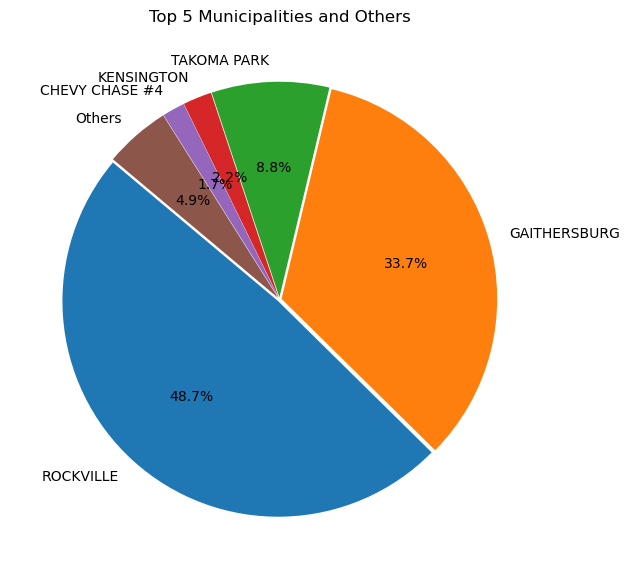

In [20]:
# Plot Pie Chart

grouped_df1 = (
    reduced_car_crash_df
    .groupby("Municipality")
    .size()
    .reset_index(name='num_of_accident')
    .sort_values(by="num_of_accident", ascending=False)
    .reset_index(drop=True)
)

# Calculate the top 5 and the sum of the rest
top_5 = grouped_df1.head(5)
others_count = grouped_df1.iloc[5:]['num_of_accident'].sum()

# Create a DataFrame for "Others"
others = pd.DataFrame({'Municipality': ['Others'], 'num_of_accident': [others_count]})

# Concatenate the top 5 with the "Others" row
top_5 = pd.concat([top_5, others], ignore_index=True)

# Plotting
labels = top_5["Municipality"]
sizes = top_5["num_of_accident"]
explode = [0.01] * len(top_5)  # Explode all slices slightly

plt.figure(figsize=(10, 7))
plt.pie(sizes, autopct="%1.1f%%", labels=labels, explode=explode, startangle=140)
plt.title('Top 5 Municipalities and Others')
plt.show()

In [34]:
# filtering the reduced_car_crash_df by the Municipality that has the most car accident between 2021 and 2024
f1_df1 = reduced_car_crash_df[(reduced_car_crash_df["Municipality"] == "ROCKVILLE") & (reduced_car_crash_df["Year"] > 2020)]
f1_df1

,Report Number,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude,Date,Time,Year,Month,Day
62,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
63,MCP25520068,Maryland (State),FREDERICK RD,RIDGEMONT AVE,HEAD ON LEFT TURN,ROCKVILLE,CLEAR,WET,TRAFFIC SIGNAL,35,39.119066,-77.171987,2023-07-25,21:57:00,2023,7,25
66,DD5652003G,Maryland (State),NORBECK RD,AVERY RD,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,50,39.093226,-77.122113,2023-07-21,14:26:00,2023,7,21
88,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,30,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
91,DD55830085,Maryland (State),HUNGERFORD DR,MANNAKEE ST,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,35,39.096320,-77.153139,2023-07-24,10:52:00,2023,7,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171864,MCP2160002L,Maryland (State),ROCKVILLE PIKE,EDMONSTON DR,SAME DIRECTION SIDESWIPE,ROCKVILLE,CLEAR,DRY,NaN,35,39.071888,-77.132846,2023-03-04,17:54:00,2023,3,4
172063,DD5652000P,Other Public Roadway,GRAND CHAMPION DR,KING FARM BLVD,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,RAINING,WET,NO CONTROLS,25,39.115416,-77.170673,2022-05-27,12:54:00,2022,5,27
172077,DD5617002X,Municipality,PRETTYMAN DR,FALLSGROVE BLVD,HEAD ON,ROCKVILLE,NaN,NaN,STOP SIGN,25,39.093896,-77.194305,2022-08-03,19:25:00,2022,8,3
172087,DD5649000V,Municipality,ROLLINS AVE,MARTHA TERR,SAME DIR REAR END,ROCKVILLE,NaN,DRY,STOP SIGN,25,39.057302,-77.133702,2021-08-19,15:50:00,2021,8,19


In [35]:
# plot the map with Latitude and Longitude to visually display which street has the most accidents
map_plot_1 = f1_df1.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    color = "Municipality",
    width=1000,
    height=800
)
map_plot_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Municipality)

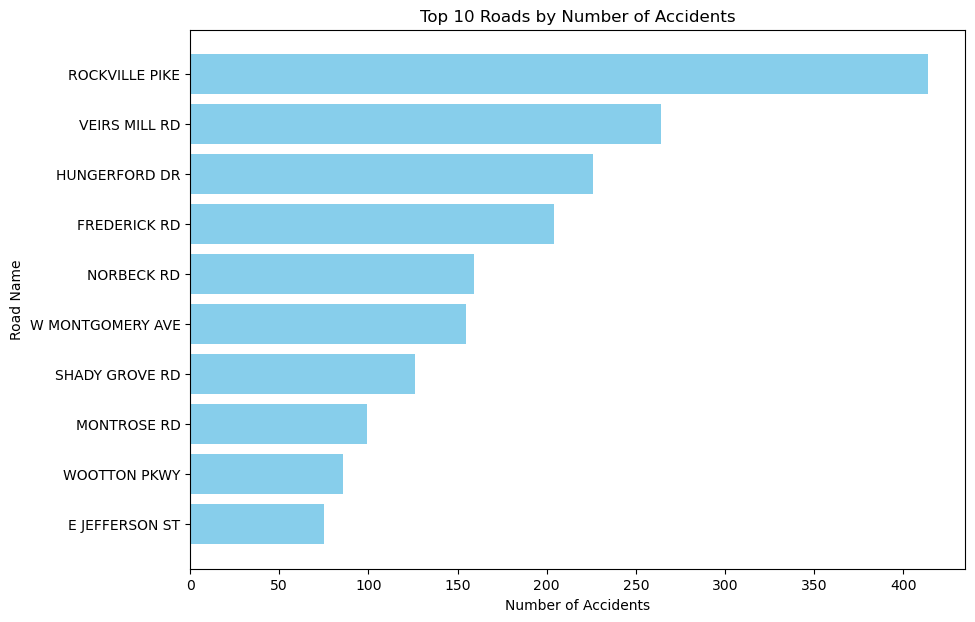

In [36]:
# Group by filtered_df1 by Road Name
f1_grouped_df1 = (
    f1_df1
    .groupby("Road Name")
    .size()
    .reset_index(name='num_of_accident')
    .sort_values(by="num_of_accident", ascending=False)
    .reset_index(drop=True)
)

# Taking the top 10 for plotting
top_10 = f1_grouped_df1.head(10)

# Plotting
plt.figure(figsize=(10, 7))
plt.barh(top_10["Road Name"], top_10["num_of_accident"], color='skyblue')
plt.xlabel('Number of Accidents')
plt.ylabel('Road Name')
plt.title('Top 10 Roads by Number of Accidents')
plt.gca().invert_yaxis()  # To have the highest values on top
plt.show()

In [37]:
f2_df = f1_df1[f1_df1["Road Name"] == "ROCKVILLE PIKE"]
f2_df

,Report Number,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude,Date,Time,Year,Month,Day
62,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
88,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,30,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
317,DD561500FH,Maryland (State),ROCKVILLE PIKE,RICHARD MONTGOMERY DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,25,39.083840,-77.153118,2023-07-25,15:20:00,2023,7,25
318,DD561500FH,Maryland (State),ROCKVILLE PIKE,RICHARD MONTGOMERY DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,35,39.083840,-77.153118,2023-07-25,15:20:00,2023,7,25
702,DD559500DS,Maryland (State),ROCKVILLE PIKE,MT VERNON PL,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLOUDY,DRY,STOP SIGN,25,39.078854,-77.142090,2023-08-05,12:15:00,2023,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169691,MCP2726005H,Maryland (State),ROCKVILLE PIKE,CONGRESSIONAL LA,OTHER,ROCKVILLE,RAINING,WET,OTHER,40,39.064598,-77.126280,2021-04-14,12:03:00,2021,4,14
169732,DD56510016,Maryland (State),ROCKVILLE PIKE,ROLLINS AVE,SAME DIRECTION SIDESWIPE,ROCKVILLE,NaN,DRY,NaN,35,39.059269,-77.121833,2021-12-14,19:14:00,2021,12,14
170973,MCP2339007K,Maryland (State),ROCKVILLE PIKE,ROLLINS AVE,SAME DIRECTION RIGHT TURN,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,35,39.058654,-77.121170,2022-10-07,16:15:00,2022,10,7
171135,DD56440025,Maryland (State),ROCKVILLE PIKE,HALPINE RD,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLOUDY,DRY,TRAFFIC SIGNAL,35,39.061794,-77.124088,2022-01-05,15:00:00,2022,1,5


In [39]:
# grouped by Speed Limit
f2_grouped_sl_df = (
    f2_df
    .groupby("Speed Limit")
    .size()
    .reset_index(name='num_of_accident')
    .sort_values(by="num_of_accident", ascending=False)
    .reset_index(drop=True)
)
f2_grouped_sl_df

,Speed Limit,num_of_accident
0,35,194
1,40,126
2,30,38
3,45,21
4,25,17
5,0,7
6,5,4
7,10,3
8,20,2
9,15,1


In [40]:
# grouped by Traffic Control Limit
f2_grouped_tc_df = (
    f2_df
    .groupby("Traffic Control")
    .size()
    .reset_index(name='num_of_accident')
    .sort_values(by="num_of_accident", ascending=False)
    .reset_index(drop=True)
)
f2_grouped_tc_df

,Traffic Control,num_of_accident
0,TRAFFIC SIGNAL,209
1,NO CONTROLS,110
2,OTHER,15
3,STOP SIGN,15
4,FLASHING TRAFFIC SIGNAL,9
5,YIELD SIGN,2
6,WARNING SIGN,1


In [41]:
# grouped by surface Condition Limit
f2_grouped_sc_df = (
    f2_df
    .groupby("Surface Condition")
    .size()
    .reset_index(name='num_of_accident')
    .sort_values(by="num_of_accident", ascending=False)
    .reset_index(drop=True)
)
f2_grouped_sc_d
# We can conclude that the surface condition does not have any relationship 

,Surface Condition,num_of_accident
0,DRY,346
1,WET,47
2,SLUSH,2
3,SNOW,1


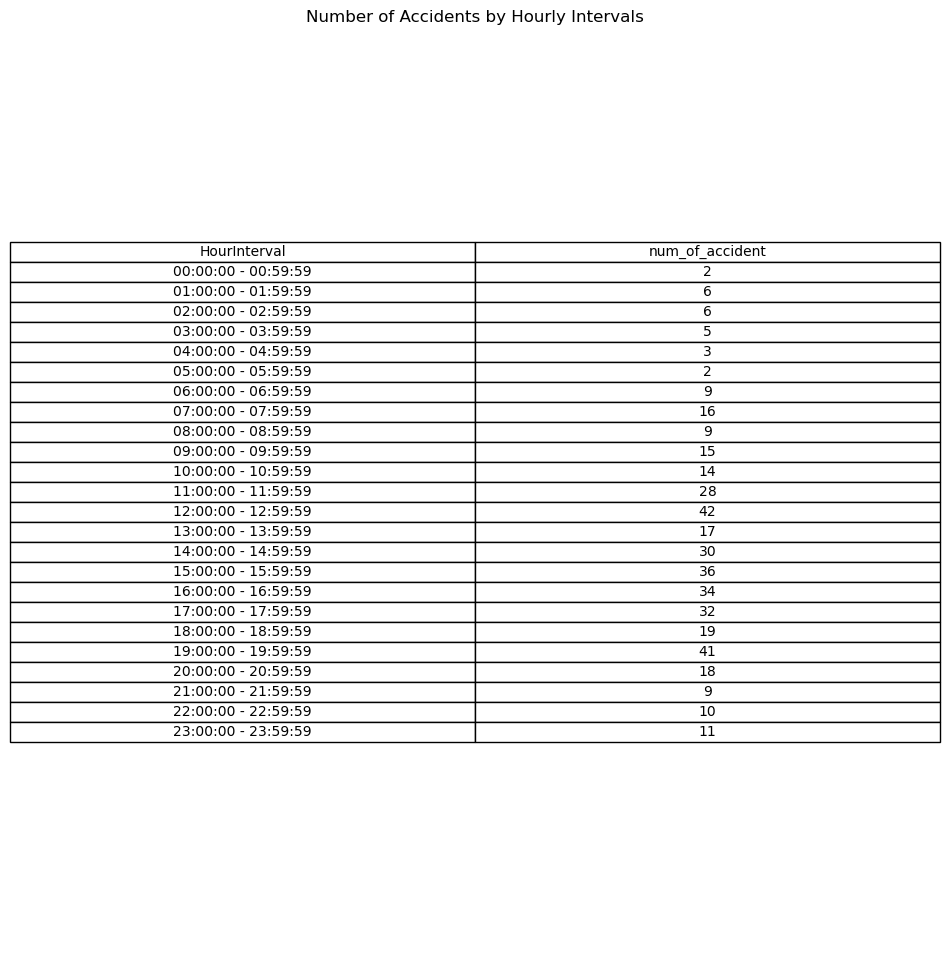

In [56]:
# Ensure the 'Time' column is in datetime format
f2_df['Time'] = pd.to_datetime(f2_df['Time'], format='%H:%M:%S')

# Create a new column for the hourly intervals
f2_df['HourInterval'] = f2_df['Time'].dt.floor('H').dt.strftime('%H:%M:%S') + ' - ' + (f2_df['Time'].dt.floor('H') + pd.Timedelta(hours=1) - pd.Timedelta(seconds=1)).dt.strftime('%H:%M:%S')

# Group by the hourly intervals and count the number of accidents
f2_grouped_tf_df = (
    f2_df
    .groupby('HourInterval')
    .size()
    .reset_index(name='num_of_accident')
    .sort_values(by='HourInterval')
    .reset_index(drop=True)
)

# Display the frequency table using Matplotlib
fig, ax = plt.subplots(figsize=(10, 12))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=f2_grouped_tf_df.values, colLabels=f2_grouped_tf_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Number of Accidents by Hourly Intervals')
plt.show()


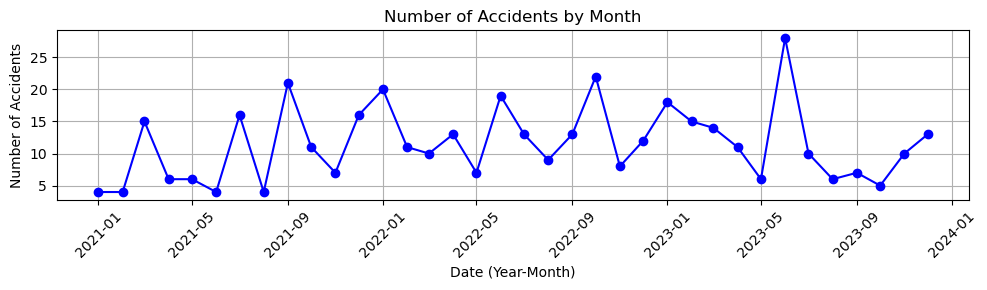

In [51]:
# plot the trend of car_crash_accidents
# Ensure the 'Date' column is in datetime format
f2_df['Date'] = pd.to_datetime(f2_df['Date'])

# Create a new column for the year-month format
f2_df['YearMonth'] = f2_df['Date'].dt.to_period('M')

# Group by the year-month column and count the number of accidents
monthly_counts = f2_df.groupby('YearMonth').size().reset_index(name='num_of_accident')

# Convert the 'YearMonth' column back to datetime for plotting
monthly_counts['YearMonth'] = monthly_counts['YearMonth'].dt.to_timestamp()

# Plotting the line graph
plt.figure(figsize=(10, 3))
plt.plot(monthly_counts['YearMonth'], monthly_counts['num_of_accident'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents by Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add gridlines for better visualization
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

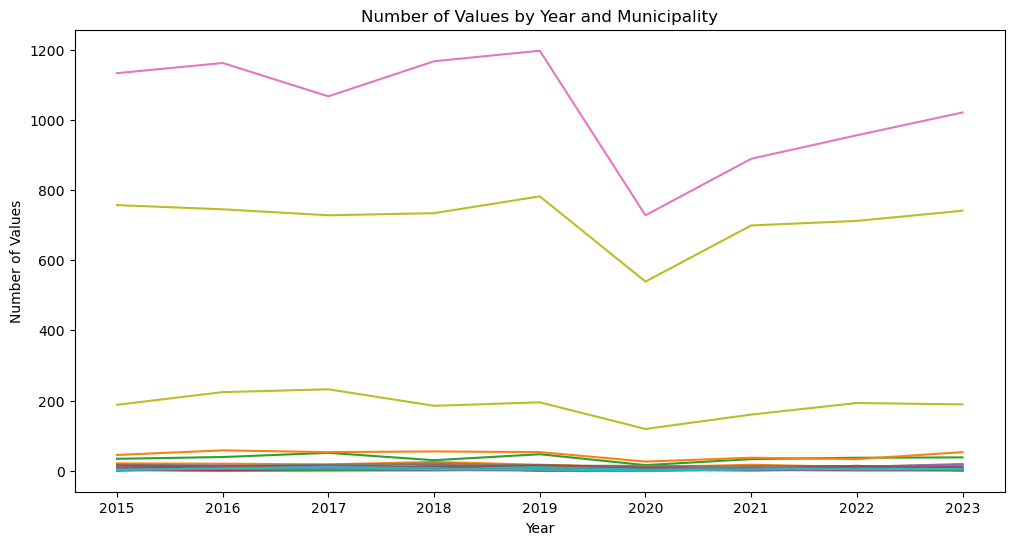

In [10]:
## leave this line graph for an example

df = reduced_car_crash_df.groupby(['Year', 'Municipality']).size().reset_index(name='Count')

pivot_df = df.pivot(index='Year', columns='Municipality', values='Count').fillna(0)
pivot_df
# Plotting
plt.figure(figsize=(12, 6))

for municipality in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[municipality], label=municipality)

plt.xlabel('Year')
plt.ylabel('Number of Values')
plt.title('Number of Values by Year and Municipality')
plt.show()